In [1]:
!pip install catboost
!pip install shap
!pip install tsfresh

In [2]:
# The essentials
import pandas as pd
import numpy as np

from collections import defaultdict

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt

# Progress bars
from tqdm import tqdm

# Access our Google Drive
from google.colab import drive

# Gradient Boosting
from catboost import CatBoostRegressor, Pool

# TSFRESH Feature Extraction
from tsfresh import extract_features
from tsfresh.feature_extraction import EfficientFCParameters
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_selection.relevance import calculate_relevance_table

from sklearn.model_selection import KFold

from collections import defaultdict, Counter
from scipy.stats import norm

import shap

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
drive.mount('/content/drive', force_remount=True)
!ls "/content/drive/My Drive/Rinse Over Run"

Mounted at /content/drive
20178.png
20451.png
20899.png
22112.png
22369.png
22414.png
22487.png
23011.png
23142.png
23599.png
23872.png
24804.png
24845.png
24872.png
25129.png
25908.png
25983.png
26270.png
27115.png
27243.png
27346.png
27366.png
27418.png
27508.png
all_train_preds_per_phase.p
baseline_features_with_preds_per_phase.csv
baseline_model_per_nunique_phases.csv
better_prev_object_id_per_10.csv
dtw_distances_3.p
extended_phase_predictors.csv
last_cleaned_test.csv
last_cleaned_train.csv
mds_embeddings_2d_3.csv
mds_embeddings_2d_3.p
model_per_recipe_simple.csv
more_features_with_preds_per_phase.csv
pca_features_with_preds_per_phase.csv
predictions_machine_405.csv
preds_feature_selection.csv
processes_all_phases.p
process_machine_outlier_predicted.csv
recipe_8_augmented.csv
recipe_metadata.csv
recipe_model_all_tsfresh_bitmaps.csv
recipe_model_prev_process_tsfresh.csv
supertest.csv
test_features_14.csv
test_features_15.csv
test_features_1.csv
test_features_2.csv
test_features_3.c

In [4]:
train_df = pd.read_csv('/content/drive/My Drive/Rinse Over Run/train_values.csv', index_col=0, parse_dates=['timestamp'])
test_df = pd.read_csv('/content/drive/My Drive/Rinse Over Run/test_values.csv', index_col=0, parse_dates=['timestamp'])
label_df = pd.read_csv('/content/drive/My Drive/Rinse Over Run/train_labels.csv', index_col='process_id')

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [0]:
train_df = train_df[train_df['phase'] != 'final_rinse']

train_df['phase_int'] = train_df['phase'].map({'pre_rinse': 1, 
                                               'caustic': 2, 
                                               'intermediate_rinse': 4, 
                                               'acid': 8})
test_df['phase_int'] = test_df['phase'].map({'pre_rinse': 1, 
                                             'caustic': 2, 
                                             'intermediate_rinse': 4, 
                                             'acid': 8})
train_process_combinations = pd.DataFrame(train_df.groupby('process_id')['phase_int'].unique().apply(lambda x: sum(x)))
test_process_combinations = pd.DataFrame(test_df.groupby('process_id')['phase_int'].unique().apply(lambda x: sum(x)))
process_combinations = pd.concat([train_process_combinations, test_process_combinations], axis=0)

recipe_df = pd.read_csv('/content/drive/My Drive/Rinse Over Run/recipe_metadata.csv', index_col='process_id')
recipe_df = recipe_df.drop('final_rinse', axis=1)
recipe_df['pre_rinse_num'] = recipe_df['pre_rinse'] * 1
recipe_df['caustic_num'] = recipe_df['caustic'] * 2
recipe_df['intermediate_rinse_num'] = recipe_df['intermediate_rinse'] * 4
recipe_df['acid_num'] = recipe_df['acid'] * 8
recipe_df['recipe'] = recipe_df['pre_rinse_num'] + recipe_df['caustic_num'] + recipe_df['intermediate_rinse_num'] + recipe_df['acid_num']

In [0]:
ts_real = [
    'supply_flow',
    'supply_pressure',
    'return_temperature',
    'return_conductivity',
    'return_turbidity',
    'return_flow',
    'tank_level_pre_rinse',
    'tank_level_caustic',
    'tank_level_acid',
    'tank_level_clean_water',
    'tank_temperature_pre_rinse',
    'tank_temperature_caustic',
    'tank_temperature_acid',
    'tank_concentration_caustic',
    'tank_concentration_acid',
    'target_value',
    'flow_diff',
    'supply_flow_log',
    'return_flow_log'
]

# variables we'll use to create our time series features
ts_cols = [
    'supply_flow',
    'supply_pressure',
    'return_temperature',
    'return_conductivity',
    'return_turbidity',
    'return_flow',
    'tank_level_pre_rinse',
    'tank_level_caustic',
    'tank_level_acid',
    'tank_level_clean_water',
    'tank_temperature_pre_rinse',
    'tank_temperature_caustic',
    'tank_temperature_acid',
    'tank_concentration_caustic',
    'tank_concentration_acid',
    'target_value',
    'flow_diff',
    'supply_flow_log',
    'return_flow_log'
]

# variables for binary time series features
bin_cols = [
    'supply_pump',
    'supply_pre_rinse',
    'supply_caustic',
    'return_caustic',
    'supply_acid',
    'return_acid',
    'supply_clean_water',
    'return_recovery_water',
    'return_drain',
    'object_low_level',
    'tank_lsh_caustic',
    'tank_lsh_acid',
    'tank_lsh_clean_water',
    'tank_lsh_pre_rinse'
]

process_comb_to_phases = {
    15: ['pre_rinse', 'caustic', 'intermediate_rinse', 'acid'],
    3:  ['pre_rinse', 'caustic'],
    7:  ['pre_rinse', 'caustic', 'intermediate_rinse'],
    1:  ['pre_rinse'],
    8:  ['acid'],
    2:  ['caustic'],
    6:  ['caustic', 'intermediate_rinse'],
    14: ['caustic', 'intermediate_rinse', 'acid'],
}

# phases, ordered from earliest to latest
phases = ['pre_rinse', 'caustic', 'intermediate_rinse', 'acid']

def encode_categorical(df):
    # Currently just copy-pasted from http://drivendata.co/blog/rinse-over-run-benchmark/
    
    # select process_id and pipeline
    meta = df[['process_id', 'pipeline', 'object_id']].drop_duplicates().set_index('process_id') 
    meta['object_id'] = meta['object_id'] // 10
    #meta = meta.merge(recipe_df[['recipe', 'pre_rinse', 'caustic', 'intermediate_rinse', 'acid']], left_index=True, right_index=True)
    meta = meta.merge(process_combinations[['phase_int']], left_index=True, right_index=True)
    
    # convert categorical pipeline data to dummy variables
    meta = pd.get_dummies(meta, columns=['pipeline', 'object_id', 'phase_int'])
    
    # pipeline L12 not in test data (so useless feature)
    if 'pipeline_L12' in meta:
        meta = meta.drop('pipeline_L12', axis=1)
    
    # calculate number of phases for each process_object
    meta['num_phases'] = df.groupby('process_id')['phase'].apply(lambda x: x.nunique())
    #meta['object_id'] = df.groupby('process_id')['object_id'].median()
    
    return meta
  
def encode_real_timeseries(df):   
    ts_df = df[['process_id'] + ts_cols].set_index('process_id')
    
    # create features: count, min, max, mean, standard deviation
    ts_features = ts_df.groupby('process_id').agg(['min', 'max', 'mean', 'std', 
                                                   'count', 'median', 'sum', 
                                                   lambda x: x.tail(5).mean()])
    
    cols = []
    for col in ts_features.columns:
        cols.append('real_{}'.format(col))
    ts_features.columns = cols
    
    return ts_features

def encode_binary_timeseries(df):
    ts_df = df[['process_id'] + bin_cols].set_index('process_id')
            
    # create features: count, min, max, mean, standard deviation
    ts_features = ts_df.groupby('process_id').agg(['mean', 'std', 
                                                   lambda x: x.tail(5).mean()])
    
    cols = []
    for col in ts_features.columns:
        cols.append('bin_{}'.format(col))
    ts_features.columns = cols
    
    return ts_features

def get_descript(data, functions, cols):
    ts_df = data.set_index('process_id').sort_values(by='timestamp')
    return ts_df.groupby('process_id')[cols].agg(functions)  

  
def get_descript_prev_process(data, data_procs):
    machines = set(data['object_id'])
    all_features = []
    for machine in tqdm(machines):
        machine_data = data[data['object_id'] == machine]
        machine_data = machine_data.sort_values(by='timestamp')
        machine_processes = machine_data['process_id'].unique()
        for process_ix, process in enumerate(machine_processes):
          if process in data_procs:
            if process_ix > 0:
                prev_process = machine_data[machine_data['process_id'] == machine_processes[process_ix - 1]]
                last_phase = None
                for phase in phases:
                  if phase in set(prev_process['phase']):
                    last_phase = phase
                prev_process = prev_process[prev_process['phase'] == last_phase]
                
                features = get_descript(prev_process, ['mean', 'std', 'min', 'max', 'count'], ts_cols)
                _columns = list(features.columns)
                assert len(features) == 1
                features = features.iloc[0, :].values
                
                this_process = machine_data[machine_data['process_id'] == machine_processes[process_ix]]
                prev_recipe = recipe_df.loc[machine_processes[process_ix - 1]]['recipe']
                prev_phase_int = process_combinations.loc[machine_processes[process_ix - 1]]['phase_int']
                time_delta = (this_process['timestamp'].values[0] - prev_process['timestamp'].values[-1]) / np.timedelta64(1, 'h')
                assert time_delta > 0
                all_features.append([machine, process, time_delta, prev_recipe, prev_phase_int] + list(features))
            else:
                all_features.append([machine, process, np.NaN, np.NaN, np.NaN]  + ([np.NaN] * 60))
   
    all_features = pd.DataFrame(all_features, columns=['object_id', 'process_id', 'time_delta', 'recipe', 'phase_int'] + _columns)
    all_features = all_features.set_index('process_id', drop=True)
    col_map = {}
    for col in all_features.columns:
        col_map[col] = 'prev_{}'.format(col)
    all_features = all_features.rename(columns=col_map)
    all_features = all_features.drop('prev_object_id', axis=1)
    return all_features
  
def get_tsfresh_features(df):
    extraction_settings = EfficientFCParameters()
    filtered_funcs = ['last_location_of_maximum', 'first_location_of_maximum', 'longest_strike_below_mean', 'last_location_of_minimum',
                      'absolute_sum_of_changes', 'skewness', 'kurtosis', 'longest_strike_above_mean']
    filtered_settings = {}
    for func in filtered_funcs:
      filtered_settings[func] = extraction_settings[func]

    ts_features = extract_features(df[['process_id', 'timestamp', 'return_turbidity', 'return_flow', 'supply_flow', 'return_temperature', 'return_conductivity', 'supply_pressure', 'target_value', 'flow_diff']], 
                                   column_id='process_id', column_sort="timestamp", 
                                   column_kind=None, column_value=None,
                                   impute_function=impute, 
                                   default_fc_parameters=filtered_settings,
                                   show_warnings=False)
  
    return ts_features
                                       

def create_feature_matrix(df, processes, phases):
    df['return_flow_relu'] = df['return_flow'].apply(lambda x: max(0, x))
    df['supply_flow_relu'] = df['supply_flow'].apply(lambda x: max(0, x))
    df['target_value'] = df['return_flow_relu'] * df['return_turbidity']
    df['flow_diff'] = df['supply_flow'] - df['return_flow']
    
    df['return_flow_log'] = np.log1p(df['return_flow_relu'])
    df['supply_flow_log'] = np.log1p(df['supply_flow_relu'])
    
    phase_data = df[(df['process_id'].isin(processes)) &
                    ((df['phase'].isin(phases)))]
    
    #prev_features = get_descript_prev_process(df, processes)
    #prev_features = pd.get_dummies(prev_features, columns=['prev_recipe', 'prev_phase_int'])
    
    metadata = encode_categorical(phase_data)
    time_series = encode_real_timeseries(phase_data)
    binary_features = encode_binary_timeseries(phase_data)
    #tsfresh_features = get_tsfresh_features(phase_data)
    
    # join metadata and time series features into a single dataframe
    feature_matrix = metadata
    feature_matrix = feature_matrix.merge(time_series, left_index=True, right_index=True)
    feature_matrix = feature_matrix.merge(binary_features, left_index=True, right_index=True)
    #feature_matrix = feature_matrix.merge(prev_features, left_index=True, right_index=True)
    #feature_matrix = feature_matrix.merge(tsfresh_features, left_index=True, right_index=True)
    
    return feature_matrix
    
  
def get_processes(data, phases, train=True):
    filtered_processes = []
    phases = set(phases)
    processes = set(data['process_id'])
    for process in processes:
        process_phases = set(data[data['process_id'] == process]['phase'])
        if train:
            if phases.issubset(process_phases):
                filtered_processes.append(process)
        else:
            if len(phases) == len(process_phases) == len(phases.intersection(process_phases)):
                filtered_processes.append(process)
    return filtered_processes

In [0]:

from scipy.special import inv_boxcox

def custom_mape(approxes, targets):
    return np.mean(np.abs(np.subtract(approxes, targets)) / np.maximum(np.abs(targets), 290000))

def mape_1_row(x):
  return abs(x['prediction'] - x['target']) / max(290000, x['target'])

def mape_xgb(preds, dtrain):
  grad = -100*((preds-dtrain)/dtrain)
  hess = 100/(dtrain)
  return grad,hess

class MAPEMetric(object):
    def __init__(self, lambda_value):
        self.lambda_value = lambda_value
        
    def get_final_error(self, error, weight):
        return error

    def is_max_optimal(self):
        return False

    def evaluate(self, approxes, targets, weight):
        approxes = inv_boxcox(approxes, self.lambda_value)
        targets = inv_boxcox(targets, self.lambda_value)
        return custom_mape(approxes, targets), len(targets)

In [0]:
#from tsfresh.feature_selection.relevance import calculate_relevance_table

def get_corr_features(X):
  row_idx, col_idx = np.where(X.corr() == 1)
  self_corr = set([(i, i) for i in range(X_train.shape[1])])
  return set(list(zip(row_idx, col_idx))) - self_corr 

def get_uncorr_features(data):
  X_train_corr = data.copy()
  correlated_features = get_corr_features(X_train_corr)
  
  corr_cols = set()
  for row_idx, col_idx in correlated_features:
    corr_cols.add(row_idx)
    corr_cols.add(col_idx)
  
  uncorr_cols = list(set(X_train.columns) - set(X_train.columns[list(corr_cols)]))
   
  col_mask = [False]*X_train_corr.shape[1]
  for col in corr_cols:
    col_mask[col] = True
  X_train_corr = X_train_corr.loc[:, col_mask]
  
  correlated_features = get_corr_features(X_train_corr)
  
  while correlated_features:
    print('{} correlated feature pairs left...'.format(len(correlated_features)))
    corr_row, corr_col = correlated_features.pop()
    col_mask = [True]*X_train_corr.shape[1]
    col_mask[corr_row] = False
    X_train_corr = X_train_corr.loc[:, col_mask]
    correlated_features = get_corr_features(X_train_corr)
  return list(set(list(X_train_corr.columns) + uncorr_cols))

def remove_features(data, target, p_val=0.25):
  single_cols = list(data.columns[data.nunique() == 1])
  
  uncorr_cols = get_uncorr_features(data)
  corr_cols = list(set(data.columns) - set(uncorr_cols))
  
#   rel_table = calculate_relevance_table(data.dropna(axis=1), target, 
#                                         ml_task='regression')
#   irrel_cols = list(rel_table[rel_table['p_value'] < p_val]['feature'])
  
#   na_cols = data.columns[data.isnull().sum() > 1]
#   data_na = data[na_cols].dropna(axis=0)
#   rel_table_na = calculate_relevance_table(data_na, target.loc[data_na.index], ml_task='regression')
#   irrel_na_cols = list(rel_table_na[rel_table_na['p_value'] < p_val]['feature'])
  
  return list(set(single_cols + corr_cols))# + irrel_cols + irrel_na_cols

def bootstrap(X_train, y_train, X_test, n_models=3):
    models = []
    predictions = []
    for _ in range(n_models):
        # Bootstrap the data
        bs_idx = np.random.choice(X_train.index, replace=True, size=len(X_train))
        X_train_bs = X_train.loc[bs_idx]
        y_train_bs = y_train.loc[bs_idx]
        
        # Create a validation set
        train_idx = np.random.choice(X_train_bs.index, replace=False, size=int(0.9 * len(X_train_bs)))
        val_idx = list(set(X_train_bs.index) - set(train_idx))

        X_val_sub = X_train_bs.loc[val_idx, :]
        y_val_sub = y_train_bs.loc[val_idx]
        X_train_sub = X_train_bs.loc[train_idx, :]
        y_train_sub = y_train_bs.loc[train_idx]
        
        # Remove useless features
        to_drop = remove_features(X_train_sub, y_train_sub)
        
        X_train_sub = X_train_sub.drop(to_drop, axis=1)
        X_val_sub = X_val_sub.drop(to_drop, axis=1)
        X_test_sub = X_test.drop(to_drop, axis=1)
        
        print(X_train_sub.shape, X_val_sub.shape)
        
        cat = CatBoostRegressor(iterations=100000, od_type='Iter', od_wait=100, 
                                learning_rate=0.33, 
                                loss_function='MAPE', eval_metric=MAPEMetric())
        cat.fit(X_train_sub, y_train_sub, eval_set=(X_val_sub, y_val_sub), verbose=50)
        
        predictions.append(cat.predict(X_test_sub))
        
    return predictions

In [0]:
recipe_train_data = train_df[train_df['process_id'].isin(recipe_df[recipe_df['recipe'] == 15].index)]
recipe_test_data = test_df[test_df['process_id'].isin(recipe_df[recipe_df['recipe'] == 15].index)]
train_processes = get_processes(recipe_train_data, process_comb_to_phases[15])
test_processes = get_processes(recipe_test_data, process_comb_to_phases[15], train=False)

train_phase_data = train_df[(train_df['process_id'].isin(train_processes)) &
                          ((train_df['phase'].isin(process_comb_to_phases[15])))]

phase_features = create_feature_matrix(train_df, train_processes, process_comb_to_phases[15])

X = phase_features.loc[list(set(train_phase_data['process_id']))]
y = np.log(label_df.loc[X.index]['final_rinse_total_turbidity_liter'])

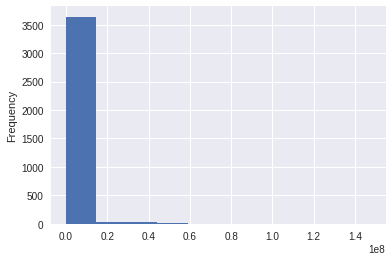

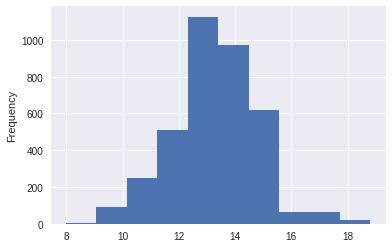

-0.015483191486114302


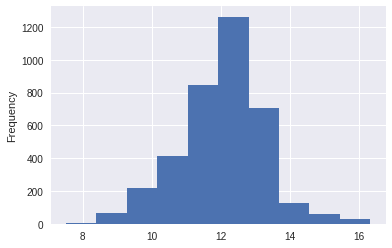

process_id
24581    7.533438e+05
24586    1.307220e+06
24588    4.122201e+06
24589    6.290355e+05
24593    4.177042e+06
24595    3.444740e+05
24599    7.501428e+05
24601    4.124742e+05
24602    5.719039e+05
24603    6.264787e+05
24605    4.481167e+05
24606    4.527481e+05
24608    1.904649e+06
24610    9.751990e+05
24611    5.927011e+05
24612    1.970118e+05
24613    3.635110e+06
24616    6.328520e+05
24617    3.188137e+05
24620    1.653329e+05
24621    6.689830e+05
24624    1.102491e+06
24627    2.865633e+06
24628    4.401686e+06
24630    4.172464e+06
24631    4.422638e+06
24632    5.967725e+05
24633    5.641746e+04
24636    1.409076e+05
24643    3.185836e+05
             ...     
24513    4.057864e+06
24515    5.605771e+05
24516    7.740348e+05
24517    6.248030e+05
24519    4.401532e+06
24521    1.838185e+07
24522    1.307799e+05
24524    2.334128e+06
24525    1.957965e+06
24526    5.164684e+06
24528    8.620975e+04
24530    6.586722e+05
24536    1.355578e+07
24537    5.488348e+05

In [65]:
# X = X[X['pipeline_L1'] == 1]
from scipy.stats import boxcox
from scipy.special import inv_boxcox
label_df.loc[X.index]['final_rinse_total_turbidity_liter'].plot(kind='hist')
plt.show()

y = np.log(label_df.loc[X.index]['final_rinse_total_turbidity_liter'])
pd.Series(y).plot(kind='hist')
plt.show()

y, maxlog = boxcox(label_df.loc[X.index]['final_rinse_total_turbidity_liter'])
y = pd.Series(y, index=X.index)
print(maxlog)
pd.Series(y).plot(kind='hist')
plt.show()

print(inv_boxcox(y, maxlog), label_df.loc[X.index].head(5)['final_rinse_total_turbidity_liter'].values)

In [68]:
#@title Default title text
prediction_df = None
shaps = []
kf = KFold(n_splits=5, random_state=2019)
for train_idx, test_idx in kf.split(X, y):
  X_train = X.iloc[train_idx, :]
  X_test = X.iloc[test_idx, :]

  y_train = y.iloc[train_idx]
  y_test = y.iloc[test_idx]

  train_idx = np.random.choice(X_train.index, replace=False, size=int(0.9 * len(X_train)))
  val_idx = list(set(X_train.index) - set(train_idx))

  X_val = X_train.loc[val_idx, :]
  y_val = y_train.loc[val_idx]
  X_train = X_train.loc[train_idx, :]
  y_train = y_train.loc[train_idx]

  to_drop = remove_features(X_train, y_train)
  print(len(to_drop), to_drop)

  X_train = X_train.drop(to_drop, axis=1)
  X_test = X_test.drop(to_drop, axis=1)
  X_val = X_val.drop(to_drop, axis=1)

  print(X_train.shape, X_val.shape, X_test.shape)

  cat = CatBoostRegressor(iterations=1000000, od_type='Iter', od_wait=100, learning_rate=0.33,
                          loss_function='Lq:q=1', eval_metric='MAPE', task_type='GPU')
  cat.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=50)
  
  explainer = shap.TreeExplainer(cat)
  shap_values = explainer.shap_values(X)
  shaps.append(shap_values)
  
  predictions = inv_boxcox(cat.predict(X_test.values), maxlog)
  mape = custom_mape(predictions, inv_boxcox(y_test, maxlog))
  print('TEST MAPE = {}'.format(mape))
  
  sub_predictions_df = pd.DataFrame(
      np.hstack((np.reshape(predictions, (-1, 1)), np.reshape(inv_boxcox(y_test.values, maxlog), (-1, 1)))), 
      columns=['prediction', 'target']
  )
  sub_predictions_df.index = X_test.index
  sub_predictions_df.index.name = X_test.index.name

  if prediction_df is None:
      prediction_df = sub_predictions_df
  else:
      prediction_df = pd.concat([prediction_df, sub_predictions_df])

356 correlated feature pairs left...
320 correlated feature pairs left...
286 correlated feature pairs left...
254 correlated feature pairs left...
224 correlated feature pairs left...
196 correlated feature pairs left...
170 correlated feature pairs left...
146 correlated feature pairs left...
124 correlated feature pairs left...
104 correlated feature pairs left...
86 correlated feature pairs left...
70 correlated feature pairs left...
56 correlated feature pairs left...
44 correlated feature pairs left...
34 correlated feature pairs left...
26 correlated feature pairs left...
20 correlated feature pairs left...
18 correlated feature pairs left...
16 correlated feature pairs left...
14 correlated feature pairs left...
12 correlated feature pairs left...
10 correlated feature pairs left...
6 correlated feature pairs left...
4 correlated feature pairs left...
2 correlated feature pairs left...
41 ['pipeline_L8', "bin_('tank_lsh_clean_water', 'std')", "real_('supply_pressure', 'count')"

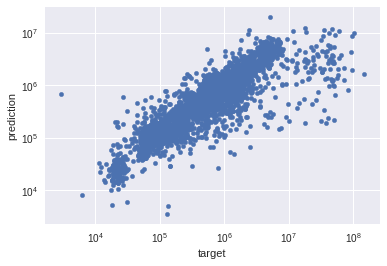

In [69]:
prediction_df.plot(kind='scatter', x='target', y='prediction', logx=True, logy=True)

In [70]:
bad_predictions = prediction_df[prediction_df['prediction'] > (2 * prediction_df['target'])]
bad_predictions['mape'] = np.abs(bad_predictions['prediction'] - bad_predictions['target']) / np.maximum(bad_predictions['target'], 290000)
print(custom_mape(bad_predictions['prediction'], bad_predictions['target']) * (len(bad_predictions) / len(prediction_df)), len(prediction_df), len(bad_predictions))
print(custom_mape(prediction_df['prediction'].values, prediction_df['target'].values))
print(list(set(prediction_df.index) - set(bad_predictions.index)))
bad_predictions.sort_values(by='mape', ascending=False)

0.07309920249742516 3726 236
0.3203270229433847
[24581, 24586, 24588, 24589, 24593, 24595, 24599, 24601, 24602, 24603, 24605, 24606, 24608, 24610, 24611, 24613, 24616, 24617, 24620, 24621, 24624, 24627, 24628, 24630, 24631, 24632, 24633, 24645, 24649, 24654, 24657, 24659, 24660, 24661, 24663, 24664, 24665, 24666, 24667, 24670, 24673, 24674, 24675, 24680, 24682, 24685, 24686, 24696, 24698, 24699, 24700, 24701, 24702, 24705, 24707, 24708, 24709, 24714, 24715, 24717, 24718, 24722, 24726, 24728, 24729, 24732, 24735, 24739, 24741, 24742, 24743, 24744, 24746, 24747, 24749, 24752, 24753, 24754, 24755, 24757, 24758, 24763, 24764, 24765, 24766, 24767, 24768, 24769, 24771, 24772, 24774, 24775, 24776, 24779, 24781, 24783, 24785, 24790, 24791, 24794, 24795, 24797, 24802, 24803, 24804, 24807, 24810, 24813, 24814, 24815, 24817, 24818, 24819, 24820, 24822, 24823, 24824, 24825, 24826, 24827, 24830, 24832, 24835, 24838, 24839, 24840, 24841, 24846, 24848, 24850, 24851, 24852, 24854, 24860, 24861, 24862,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,prediction,target,mape
process_id,,,
26167,4.966020e+06,5.368642e+05,8.250048
26029,1.633877e+06,2.603166e+05,4.736415
21914,1.531589e+06,2.793296e+05,4.318134
23458,1.500283e+06,2.881740e+05,4.179687
24711,1.391126e+06,2.464459e+05,3.947172
25893,1.365698e+06,2.357479e+05,3.896378
25781,2.977854e+06,6.265232e+05,3.752983
24812,1.689518e+06,3.588181e+05,3.708563
27306,2.687184e+06,5.792718e+05,3.638899


In [36]:
bad_predictions.describe()

,prediction,target,mape
count,1.720000e+02,1.720000e+02,172.000000
mean,8.277929e+05,3.151619e+05,1.024476
std,1.111687e+06,4.675240e+05,0.884463
min,2.328188e+04,2.939606e+03,0.040141
25%,1.845980e+05,6.006701e+04,0.367273
50%,4.336934e+05,1.231065e+05,0.923232
75%,1.141851e+06,4.273013e+05,1.307351
max,7.307281e+06,3.075390e+06,4.888842


In [37]:
prediction_df.describe()

,prediction,target
count,3.726000e+03,3.726000e+03
mean,1.073515e+06,2.117314e+06
std,1.323223e+06,7.034158e+06
min,7.798811e+03,2.939606e+03
25%,2.402384e+05,2.428570e+05
50%,5.754989e+05,6.194291e+05
75%,1.180956e+06,1.516852e+06
max,1.014948e+07,1.473866e+08


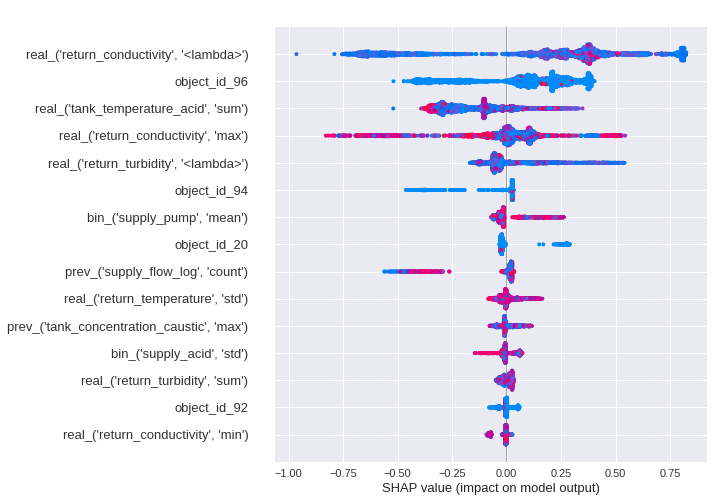

In [13]:
shap.summary_plot(np.mean(shaps, axis=0), X, max_display=15, 
                auto_size_plot=True, show=False, color_bar=False)
plt.gcf().set_size_inches(15, 8)
plt.subplots_adjust(left=0.5)
plt.show()

In [0]:
train_df = pd.read_csv('/content/drive/My Drive/Rinse Over Run/train_values.csv', index_col=0, parse_dates=['timestamp'])

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [0]:
process_27306 = train_df[train_df['process_id'] == 27306]

6052803.066973645 7113445.819004938 -1060642.7520312928
68357443.636526 59606116.08321397 8751327.553312033


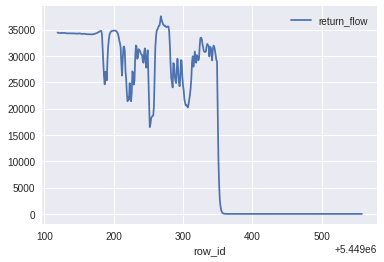

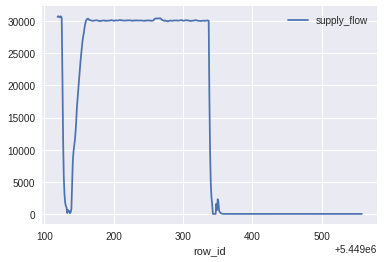

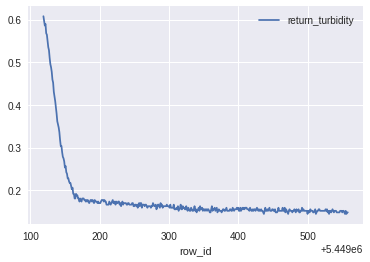

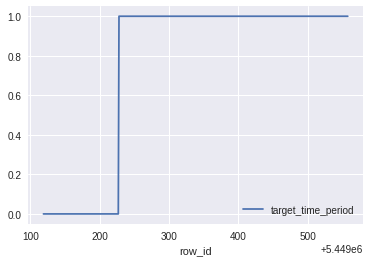

In [0]:
process_27306[process_27306['phase'] == 'final_rinse'][['return_flow']].plot()
process_27306[process_27306['phase'] == 'final_rinse'][['supply_flow']].plot()
process_27306[process_27306['phase'] == 'final_rinse'][['return_turbidity']].plot()
process_27306[process_27306['phase'] == 'final_rinse'][['target_time_period']].astype(int).plot()

process_27306_fr = process_27306[process_27306['phase'] == 'final_rinse']
process_27306_no_fr = process_27306[process_27306['phase'] != 'final_rinse']

print(sum(process_27306_fr['supply_flow']), sum(process_27306_fr['return_flow']), sum(process_27306_fr['supply_flow']) - sum(process_27306_fr['return_flow']))
print(sum(process_27306_no_fr['supply_flow']), sum(process_27306_no_fr['return_flow']), sum(process_27306_no_fr['supply_flow']) - sum(process_27306_no_fr['return_flow']))

In [16]:
X_no_27306 = X.loc[list(set(X.index) - {27306})]
y_no_27306 = y.loc[X_no_27306.index]

train_idx = np.random.choice(X_no_27306.index, replace=False, size=int(0.9 * len(X_no_27306)))
val_idx = list(set(X_no_27306.index) - set(train_idx))

X_val = X_no_27306.loc[val_idx, :]
y_val = y_no_27306.loc[val_idx]
X_train = X_no_27306.loc[train_idx, :]
y_train = y_no_27306.loc[train_idx]

cat = CatBoostRegressor(iterations=100000, od_type='Iter', od_wait=100, learning_rate=0.1,
                        loss_function='Quantile:alpha=0.9', eval_metric='MAPE', task_type='GPU')
cat.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=50)
  
explainer = shap.TreeExplainer(cat)

0:	learn: 0.9932309	test: 0.9931325	best: 0.9931325 (0)	total: 46.7ms	remaining: 1h 17m 45s
50:	learn: 0.6547145	test: 0.6502225	best: 0.6502225 (50)	total: 1.74s	remaining: 56m 50s
100:	learn: 0.3160339	test: 0.3070779	best: 0.3070779 (100)	total: 3.22s	remaining: 53m 4s
150:	learn: 0.0543318	test: 0.0512626	best: 0.0512626 (150)	total: 4.74s	remaining: 52m 12s
200:	learn: 0.0424339	test: 0.0456302	best: 0.0414866 (171)	total: 6.64s	remaining: 54m 59s
250:	learn: 0.0415962	test: 0.0459308	best: 0.0414866 (171)	total: 8.44s	remaining: 55m 54s
bestTest = 0.04148663784
bestIteration = 171
Shrink model to first 172 iterations.


In [17]:
shap_values = explainer.shap_values(X)

index_27306 = list(X.index).index(27306)

print(y.iloc[index_27306])

# visualize the first prediction's explanation
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[index_27306,:], X.iloc[index_27306,:])

13.269527103012544


In [0]:
# shap_values = explainer.shap_values(X)

# index_27306 = list(X.index).index(27631)

# print(y.iloc[index_27306])

# # visualize the first prediction's explanation
# shap.initjs()
# shap.force_plot(explainer.expected_value, shap_values[index_27306,:], X.iloc[index_27306,:])

In [0]:
from collections import Counter
Counter(train_df[train_df['process_id'].isin(bad_predictions.index)][['process_id', 'object_id']].drop_duplicates()['object_id'])

Counter({102: 6,
         107: 2,
         108: 3,
         111: 3,
         112: 20,
         113: 14,
         114: 7,
         115: 5,
         116: 4})

In [0]:
Counter(train_df[['object_id', 'process_id']].drop_duplicates()['object_id'])

Counter({102: 50,
         103: 7,
         107: 21,
         108: 20,
         109: 21,
         110: 21,
         111: 18,
         112: 125,
         113: 107,
         114: 76,
         115: 54,
         116: 88,
         204: 165,
         205: 45,
         210: 35,
         211: 34,
         212: 36,
         213: 32,
         214: 33,
         215: 50,
         216: 98,
         217: 91,
         300: 65,
         301: 64,
         302: 58,
         303: 62,
         304: 33,
         305: 48,
         306: 98,
         308: 88,
         309: 80,
         405: 350,
         409: 32,
         420: 34,
         421: 33,
         424: 6,
         426: 23,
         427: 24,
         428: 32,
         429: 31,
         431: 48,
         434: 1,
         435: 1,
         436: 1,
         437: 19,
         438: 16,
         910: 3,
         911: 41,
         912: 46,
         913: 37,
         914: 40,
         917: 40,
         918: 17,
         919: 20,
         920: 2,
         921:

In [0]:
process_combinations.loc[list(set(test_df[test_df['object_id'] == 306]['process_id']))]

,phase_int
process_id,
21632,3
22785,7
26498,15
22404,7
24456,3
20107,15
20623,3
26127,3
25233,3


In [0]:
train_df[['process_id', 'object_id']].drop_duplicates().set_index('process_id', drop=True).merge(recipe_df, left_index=True, right_index=True).groupby('object_id')['recipe'].value_counts()

object_id  recipe
102        15         48
           3           1
           9           1
103        15          7
107        15         20
           3           1
108        15         20
109        15         19
           3           1
           9           1
110        15         20
           3           1
111        15         18
112        15        125
113        15        101
           3           5
           9           1
114        15         76
115        15         53
           9           1
116        15         88
204        15        165
205        3          40
           15          5
210        3          28
           15          7
211        3          28
           15          6
212        3          30
           15          6
                    ... 
952        15         18
953        15         17
954        15         16
955        15         62
           9           1
956        15         60
957        15         30
           3           1
       